In [1]:
#I'm submitting the notebook I was already working in since it already has all the stuff the assignment asked for. Minus some pieces.



In [2]:
!pip install category_encoders

In [3]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from IPython.display import Image

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#Goal: Create a ML model that can predict approval odds of a refinance. 

dfimb = pd.read_csv('/content/loan_data.csv')

dfimb.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [5]:
#Dropping all credit card entries, since you can't refinance a credit card

dfimb.drop(dfimb.index[dfimb['purpose'] == 'credit_card'], inplace = True)

dfimb.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,0,0,1,1
7,1,all_other,0.1114,131.22,11.002100,11.08,722,5116.000000,24220,68.6,0,0,0,1


In [6]:
dfimb.shape

(8316, 14)

In [7]:
#Undesireable factors will return -1 in order to train the model on what is and isn't acceptable for a refinance. These factors will be as follows:



#Credit score at or below 650

#inquiries last 6 months are above 1

#any delinquencies in last 2 years

dfimb['refi_possible'] = 1
dfimb.loc[dfimb['fico'] <= 650, 'refi_possible' ] = 0
dfimb.loc[dfimb['inq.last.6mths'] > 1, 'refi_possible' ] = 0
dfimb.loc[dfimb['delinq.2yrs'] > 0, 'refi_possible'] = 0



In [8]:
dfimb.drop(columns=['fico', 'inq.last.6mths', 'delinq.2yrs'])

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,days.with.cr.line,revol.bal,revol.util,pub.rec,not.fully.paid,refi_possible
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,5639.958333,28854,52.1,0,0,1
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,4710.000000,3511,25.6,0,0,1
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,2699.958333,33667,73.2,0,0,1
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,3180.041667,3839,76.8,1,1,1
7,1,all_other,0.1114,131.22,11.002100,11.08,5116.000000,24220,68.6,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,10474.000000,215372,82.1,0,1,0
9574,0,all_other,0.1253,257.70,11.141862,0.21,4380.000000,184,1.1,0,1,0
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,3450.041667,10036,82.9,0,1,0
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,1800.000000,0,3.2,0,1,0


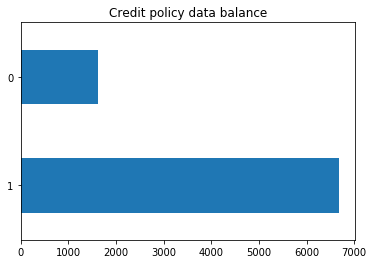

In [9]:
dfimb['credit.policy'].value_counts().plot(kind='barh', title='Credit policy data balance')

In [11]:
#count class
count_class0, count_class1 = dfimb['credit.policy'].value_counts()

#Creating 2 separate dataframes that contain the different values for credit policy. We'll use this to undersample the data.

df_class0 = dfimb[dfimb['credit.policy'] == 0]
df_class1 = dfimb[dfimb['credit.policy'] == 1]
print(df_class0.shape)
df_class1.shape

(1626, 15)


(6690, 15)

In [12]:
#Using sample function to create undersampling base. This randomizes the dataset and avoids bias. 

df_under_base = df_class1.sample(count_class1)

#concatenate results.

df = pd.concat([df_under_base, df_class0], axis=0)

df['credit.policy'].value_counts()



1    1626
0    1626
Name: credit.policy, dtype: int64

In [13]:
df.shape

(3252, 15)

In [14]:
df['credit.policy'].value_counts()


#Large imbalance in the most important parameter, as previously realized in the model. This explains why without the bagging classifier we were getting extremely variant recall.

1    1626
0    1626
Name: credit.policy, dtype: int64

In [15]:
df.drop(columns=['fico', 'delinq.2yrs', 'inq.last.6mths', 'revol.util', 'revol.bal'], inplace=True)

In [16]:
mask = {'debt_consolidation':0, 'all_other':1, 'home_improvement':2, 'small_business':3, 'major_purchase':4, 'educational':5}

df["Loan_type"] = df["purpose"].replace(mask)
df.drop(columns='purpose', inplace=True)


df.reset_index(drop=True, inplace=True)
df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,days.with.cr.line,pub.rec,not.fully.paid,refi_possible,Loan_type
0,1,0.0932,319.47,10.645425,24.37,3390.041667,0,0,0,0
1,1,0.1183,629.55,12.206093,10.93,7020.000000,0,0,1,0
2,1,0.1253,133.87,10.907167,14.12,2497.000000,0,0,1,1
3,1,0.1379,54.53,10.915088,14.68,5310.041667,0,0,1,5
4,1,0.1221,158.25,10.718941,20.95,5760.000000,0,0,1,1


In [17]:
#Splitting data

target = 'refi_possible'
y=df[target]
X=df.drop(columns=target)

In [18]:
#TTS

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state = 1)



In [19]:
#baseline acc

print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())



Baseline Accuracy: 0.5913110342176087


In [20]:
model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=1)
)
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                          

In [21]:
print("Training accuracy: ", model.score(X_train, y_train))

print("Validation accuracy: ", model.score(X_val, y_val))

#Returning 100 percent accuracy, not good.

Training accuracy:  1.0
Validation accuracy:  0.7050691244239631


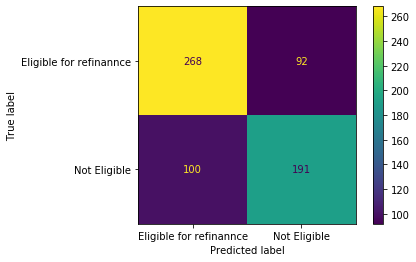

In [22]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(model, X_val,y_val, values_format = '.0f',display_labels=['Eligible for refinannce','Not Eligible'])

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df)

profile.to_notebook_iframe()

In [23]:
print(classification_report(y_val,model.predict(X_val),target_names = ['Approved','Declined']))

              precision    recall  f1-score   support

    Approved       0.73      0.74      0.74       360
    Declined       0.67      0.66      0.67       291

    accuracy                           0.71       651
   macro avg       0.70      0.70      0.70       651
weighted avg       0.70      0.71      0.70       651



In [24]:
#2nd attempt with gradient boosting.

model_gbm = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    GradientBoostingClassifier(random_state=42, learning_rate=0.7)
)

model_gbm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('gradientboostingclassifier',
                 GradientBoostingClassi...
                                            learning_rate=0.7, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_sa

In [25]:
print('Training Accuracy', model_gbm.score(X_train, y_train))
print('Validation Accuracy', model_gbm.score(X_val, y_val))

#much more reasonable than random forest.

Training Accuracy 0.9415609381007305
Validation Accuracy 0.6835637480798771


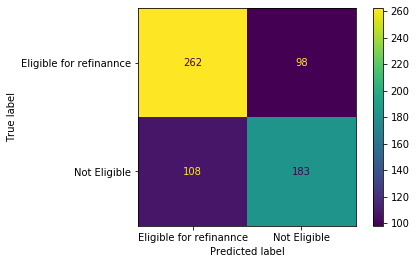

In [26]:
plot_confusion_matrix(model_gbm, X_val,y_val, values_format = '.0f',display_labels=['Eligible for refinannce','Not Eligible'])

In [27]:
print(classification_report(y_val,model_gbm.predict(X_val),target_names = ['Approved','Declined']))

              precision    recall  f1-score   support

    Approved       0.71      0.73      0.72       360
    Declined       0.65      0.63      0.64       291

    accuracy                           0.68       651
   macro avg       0.68      0.68      0.68       651
weighted avg       0.68      0.68      0.68       651



In [28]:
#Final model with xgboost


model_xg = XGBClassifier(random_state=42, n_jobs=-1)

model_xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
#xg metrics

print('Training Accuracy', model_xg.score(X_train, y_train))
print('Validation Accuracy', model_xg.score(X_val, y_val))

#slighly lower than gradient, gradient appears to be the most reliable model.

Training Accuracy 0.7893118031526336
Validation Accuracy 0.7112135176651305


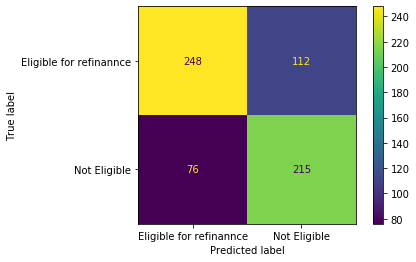

In [30]:
plot_confusion_matrix(model_xg, X_val,y_val, values_format = '.0f',display_labels=['Eligible for refinannce','Not Eligible'])

In [31]:
print(classification_report(y_val,model_xg.predict(X_val),target_names = ['Approved','Declined']))

              precision    recall  f1-score   support

    Approved       0.77      0.69      0.73       360
    Declined       0.66      0.74      0.70       291

    accuracy                           0.71       651
   macro avg       0.71      0.71      0.71       651
weighted avg       0.72      0.71      0.71       651



In [ ]:
# I will be using shap for feature visualization.

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
explainer=shap.TreeExplainer(model_xg)
shap_values=explainer(X_val)
shap.plots.waterfall(shap_values[0])

In [ ]:
!pip install pdpbox

In [ ]:
#feature visualizations

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [ ]:
features = ['int.rate', 'revol.util']
inter = pdp_interact(model_xg,
                     dataset= X_val,
                     model_features = X_val.columns,
                     features= features)



In [ ]:
pdp_interact_plot(inter,plot_type='grid',feature_names = features)